In [42]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [44]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [45]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [46]:
tf.keras.backend.clear_session()

In [47]:
subject = 'Santa Catarina - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [48]:
data = pd.read_csv('2003_mo_model_input_SC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Consumo de Cimento (t),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado
0,2003-1,0.797768,0.311113,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,142.456,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08
1,2003-2,0.797853,0.312787,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,135.829,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08
2,2003-3,0.797939,0.314207,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,133.135,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08
3,2003-4,0.798024,0.315571,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,144.723,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08
4,2003-5,0.798110,0.316880,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,150.523,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,0.663849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.461535,1017.503579,1133.235601,19.033721,14.502847,76.312831,1.691036,377.545,155.321494,NaN,NaN,NaN,NaN
236,2022-9,NaN,0.663153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.648715,1016.392164,1212.893806,19.945699,15.277015,75.825700,1.671062,370.282,154.790929,NaN,NaN,NaN,NaN
237,2022-10,NaN,0.661797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.801405,1015.809898,1255.346387,20.536577,15.826330,75.725511,1.688806,340.900,155.428377,NaN,NaN,NaN,NaN
238,2022-11,NaN,0.660090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.872772,1015.628368,1312.583382,20.906044,16.017862,75.002602,1.686804,363.900,155.448086,NaN,NaN,NaN,NaN


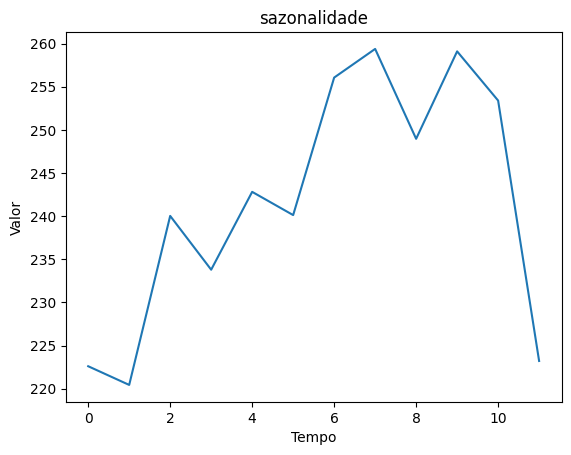

,sazonalidade
sazonalidade,
0,222.603825
1,220.438650
2,240.029525
3,233.793550
4,242.816650
5,240.124700
6,256.062200
7,259.384450
8,248.964900


In [49]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [50]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,sazonalidade,Santa Catarina - Consumo de Cimento (t)
0,2003-1,0.797768,0.311113,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,222.603825,142.456
1,2003-2,0.797853,0.312787,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,220.438650,135.829
2,2003-3,0.797939,0.314207,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,240.029525,133.135
3,2003-4,0.798024,0.315571,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,233.793550,144.723
4,2003-5,0.798110,0.316880,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,242.816650,150.523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,0.663849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.461535,1017.503579,1133.235601,19.033721,14.502847,76.312831,1.691036,155.321494,NaN,NaN,NaN,NaN,259.384450,377.545
236,2022-9,NaN,0.663153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.648715,1016.392164,1212.893806,19.945699,15.277015,75.825700,1.671062,154.790929,NaN,NaN,NaN,NaN,248.964900,370.282
237,2022-10,NaN,0.661797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.801405,1015.809898,1255.346387,20.536577,15.826330,75.725511,1.688806,155.428377,NaN,NaN,NaN,NaN,259.101100,340.900
238,2022-11,NaN,0.660090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.872772,1015.628368,1312.583382,20.906044,16.017862,75.002602,1.686804,155.448086,NaN,NaN,NaN,NaN,253.399900,363.900


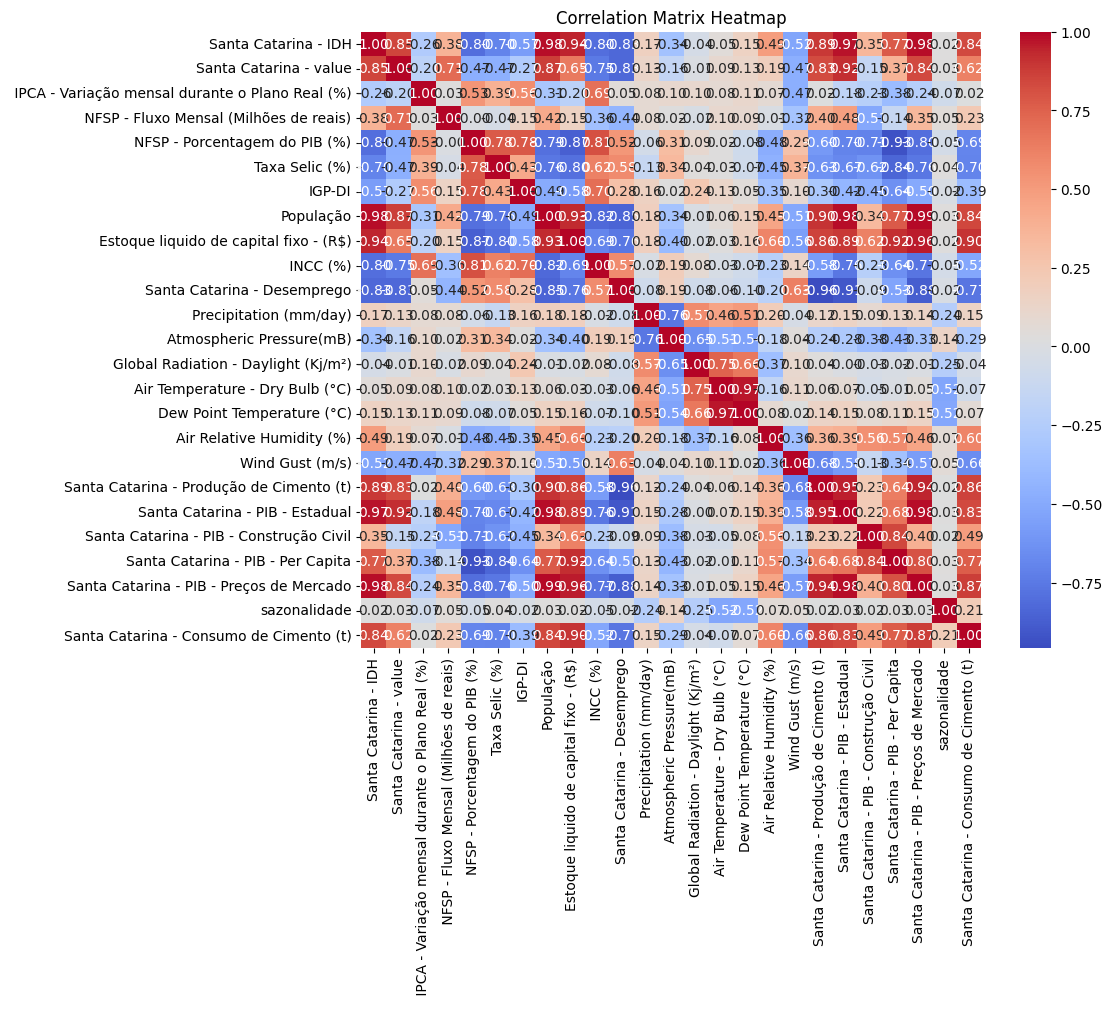

In [51]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [52]:
data = data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' IPCA - Variação mensal durante o Plano Real (%)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Temperature - Dry Bulb (°C)',
                 'Dew Point Temperature (°C)'], axis=1)
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,sazonalidade,Santa Catarina - Consumo de Cimento (t)
0,2003-1,0.797768,0.311113,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,8.256606,1.631497,1018.765911,75.767229,2.323261,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,222.603825,142.456
1,2003-2,0.797853,0.312787,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,8.250731,1.632074,1018.754803,75.775096,2.323261,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,220.438650,135.829
2,2003-3,0.797939,0.314207,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,8.244856,1.632410,1018.748324,75.779686,2.323261,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,240.029525,133.135
3,2003-4,0.798024,0.315571,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,8.238982,1.632446,1018.747630,75.780177,2.323261,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,233.793550,144.723
4,2003-5,0.798110,0.316880,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,8.233107,1.808330,1017.949265,75.676757,2.319445,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,242.816650,150.523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,0.663849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.461535,1017.503579,76.312831,1.691036,155.321494,NaN,NaN,NaN,NaN,259.384450,377.545
236,2022-9,NaN,0.663153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.648715,1016.392164,75.825700,1.671062,154.790929,NaN,NaN,NaN,NaN,248.964900,370.282
237,2022-10,NaN,0.661797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.801405,1015.809898,75.725511,1.688806,155.428377,NaN,NaN,NaN,NaN,259.101100,340.900
238,2022-11,NaN,0.660090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.872772,1015.628368,75.002602,1.686804,155.448086,NaN,NaN,NaN,NaN,253.399900,363.900


In [53]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Santa Catarina - IDH,Santa Catarina - value,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,sazonalidade
0,-2.119998,-1.030889,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,1.085359,-0.310226,0.765934,-0.727872,0.818687,-1.154511,-1.682734,-2.417084,-3.022828,-2.152611,-1.395201
1,-2.088248,-1.010380,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,1.080851,-0.308893,0.762217,-0.724174,0.818687,-1.166496,-1.664640,-2.359361,-2.949421,-2.116149,-1.553714
2,-2.056499,-0.992988,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,1.076343,-0.308115,0.760048,-0.722017,0.818687,-1.171204,-1.646546,-2.301638,-2.876014,-2.079688,-0.119456
3,-2.024750,-0.976287,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,1.071835,-0.308031,0.759816,-0.721786,0.818687,-1.176262,-1.628452,-2.243915,-2.802607,-2.043226,-0.575995
4,-1.993000,-0.960251,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,1.067328,0.098681,0.492613,-0.770393,0.811417,-1.181205,-1.610358,-2.186191,-2.729200,-2.006765,0.084591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.726097,1.713104,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-1.126590,-0.849403,0.230365,-0.011681,0.127747,0.933479,1.196588,-0.578473,0.290543,1.029069,1.297529
188,0.689854,1.722266,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-1.131368,-0.450669,-0.157519,-0.327568,0.257589,0.953950,1.189460,-0.568205,0.281308,1.023160,0.534708
189,0.653611,1.738852,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,-1.136147,0.259583,-0.395131,-0.886130,0.410228,0.982622,1.182332,-0.557938,0.272072,1.017252,1.276785
190,0.617368,1.755526,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,-1.140925,0.958241,-0.639022,-1.186030,0.395488,1.015842,1.175204,-0.547670,0.262837,1.011344,0.859397


In [54]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      135.344
1      127.693
2      151.570
3      137.044
4      134.493
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Santa Catarina - Consumo de Cimento (t), Length: 240, dtype: float64

In [55]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Santa Catarina - IDH,Santa Catarina - value,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,sazonalidade
0,-2.119998,-1.030889,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,1.085359,-0.310226,0.765934,-0.727872,0.818687,-1.154511,-1.682734,-2.417084,-3.022828,-2.152611,-1.395201
1,-2.088248,-1.010380,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,1.080851,-0.308893,0.762217,-0.724174,0.818687,-1.166496,-1.664640,-2.359361,-2.949421,-2.116149,-1.553714
2,-2.056499,-0.992988,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,1.076343,-0.308115,0.760048,-0.722017,0.818687,-1.171204,-1.646546,-2.301638,-2.876014,-2.079688,-0.119456
3,-2.024750,-0.976287,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,1.071835,-0.308031,0.759816,-0.721786,0.818687,-1.176262,-1.628452,-2.243915,-2.802607,-2.043226,-0.575995
4,-1.993000,-0.960251,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,1.067328,0.098681,0.492613,-0.770393,0.811417,-1.181205,-1.610358,-2.186191,-2.729200,-2.006765,0.084591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.514485,1.376970,1.216560,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,-0.817925,0.785994,-0.635753,0.390294,-0.252896,0.890411,1.181211,-0.551568,0.108581,0.958937,-1.553714
158,1.496494,1.401965,1.155373,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,-0.835333,0.395537,-0.146787,0.440828,-0.428457,0.883759,1.187451,-0.577579,0.126542,0.968867,-0.119456
159,1.478503,1.424150,1.056140,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,-0.852741,0.143810,0.176295,0.584898,-0.456632,0.877272,1.193692,-0.603589,0.144504,0.978796,-0.575995
160,1.460512,1.443460,1.147619,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,-0.870149,-0.232062,0.516408,0.596740,-0.411266,0.861580,1.199932,-0.629600,0.162465,0.988726,0.084591


In [56]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      135.344
1      127.693
2      151.570
3      137.044
4      134.493
        ...   
157    211.861
158    258.760
159    211.393
160    249.531
161    231.359
Name: Santa Catarina - Consumo de Cimento (t), Length: 162, dtype: float64

In [57]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [58]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 20)

In [59]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Santa Catarina - IDH,Santa Catarina - value,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,sazonalidade
126,0.730991,0.354460,-0.230612,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,-1.145081,-0.403521,0.493524,0.776978,-2.173146,1.261102,0.800980,0.503024,0.784774,0.894737,1.054305
127,0.741997,0.396550,-0.156322,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,-1.124363,-0.586085,0.276193,0.619921,-2.118864,1.264193,0.819811,0.473034,0.769927,0.903886,1.297529
128,0.753002,0.439226,-0.120008,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,-1.103645,-0.548495,-0.119712,0.403538,-2.119392,1.264246,0.838643,0.443045,0.755079,0.913035,0.534708
129,0.764008,0.479949,-0.143194,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,-1.082927,-0.504857,-0.433474,0.239724,-2.050383,1.262191,0.857474,0.413055,0.740232,0.922184,1.276785
130,0.775014,0.523578,-0.028712,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,-1.062209,-0.104198,-0.737566,0.122344,-1.946826,1.252654,0.876306,0.383065,0.725384,0.931332,0.859397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.726097,1.713104,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-1.126590,-0.849403,0.230365,-0.011681,0.127747,0.933479,1.196588,-0.578473,0.290543,1.029069,1.297529
188,0.689854,1.722266,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-1.131368,-0.450669,-0.157519,-0.327568,0.257589,0.953950,1.189460,-0.568205,0.281308,1.023160,0.534708
189,0.653611,1.738852,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,-1.136147,0.259583,-0.395131,-0.886130,0.410228,0.982622,1.182332,-0.557938,0.272072,1.017252,1.276785
190,0.617368,1.755526,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,-1.140925,0.958241,-0.639022,-1.186030,0.395488,1.015842,1.175204,-0.547670,0.262837,1.011344,0.859397


In [60]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 20)

In [61]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [62]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [63]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [64]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2567321090, 1710297279, 3059368670, 1872652552, 2891625331, 1007416082, 1944820907, 3582948280, 2466137455, 1283591505, 2469740230, 306149730, 2286744878, 153952353, 292005149, 3798880583, 126751561, 3877423506, 2205966085, 441581120, 3342943061, 2349083304, 1375642150, 2449421738, 3263949436, 3104779856, 166068660, 2253231430, 3681015250, 1111490672, 1183826226, 1860719514, 979613255, 3411717494, 2764131474, 302803740, 3686551111, 1353645955, 613960939, 2980259660, 324287677, 3408593326, 425324518, 919787666, 682358360, 1743050162, 844061533, 3180364527, 1802173480, 2673730517]


Step: 0 ___________________________________________
val_loss: 228.93768310546875
winner_seed: 2567321090


Step: 1 ___________________________________________
val_loss: 261.5384216308594


Step: 2 ___________________________________________
val_loss: 227.3881378173828
winner_seed: 3059368670


Step: 3 ___________________________________________
val_loss: 278.5016784667969


Step: 4 __________________________

In [65]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 124ms/step - loss: 43767.0977 - val_loss: 1513.3821
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 1648.6730 - val_loss: 1358.2584
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 1600.8097 - val_loss: 1391.4187
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 1971.7454 - val_loss: 1761.2064
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 1782.1917 - val_loss: 1332.5603
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 1674.8545 - val_loss: 1543.6425
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 1833.7366 - val_loss: 1392.4310
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 1572.4823 - val_loss: 1951.9846
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 1582.5482 - val_loss: 1409.2817
Epoch 10/10000
4/4 [==========================

4/4 [==============================] - 0s 9ms/step - loss: 326.0658 - val_loss: 513.5679
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 394.1864 - val_loss: 290.9411
Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 243.5972 - val_loss: 426.4078
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 274.1630 - val_loss: 331.9733
Epoch 82/10000
4/4 [==============================] - 0s 10ms/step - loss: 227.5120 - val_loss: 398.4125
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 251.0783 - val_loss: 384.7858
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 348.1883 - val_loss: 380.0729
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 215.9510 - val_loss: 415.6845
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 233.4879 - val_loss: 329.1642
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 154.7197 - val_loss: 356.0583
Epoch 156/10000
4/4 [==============================] - 0s 10ms/step - loss: 162.9949 - val_loss: 354.9261
Epoch 157/10000
4/4 [==============================] - 0s 10ms/step - loss: 197.0730 - val_loss: 351.6316
Epoch 158/10000
4/4 [==============================] - 0s 10ms/step - loss: 184.0240 - val_loss: 331.0572
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 179.4986 - val_loss: 328.8168
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 151.7155 - val_loss: 347.1906
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 145.1362 - val_loss: 332.3500
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 171.3144 - val_loss: 400.2852
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 184.1973 - val_loss: 360.5785
Epoch 164/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 10ms/step - loss: 146.5673 - val_loss: 288.7717
Epoch 233/10000
4/4 [==============================] - 0s 9ms/step - loss: 139.9794 - val_loss: 289.0121
Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 147.3108 - val_loss: 285.5491
Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.6810 - val_loss: 298.1077
Epoch 236/10000
4/4 [==============================] - 0s 11ms/step - loss: 131.9385 - val_loss: 271.9241
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 136.5653 - val_loss: 261.3827
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 128.3842 - val_loss: 328.5969
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 145.6923 - val_loss: 274.6118
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 128.2316 - val_loss: 270.4596
Epoch 241/10000
4/4 [==============================] - 0s 10ms/st

4/4 [==============================] - 0s 10ms/step - loss: 119.6182 - val_loss: 262.2430
Epoch 310/10000
4/4 [==============================] - 0s 11ms/step - loss: 134.8060 - val_loss: 232.4134
Epoch 311/10000
4/4 [==============================] - 0s 9ms/step - loss: 141.1225 - val_loss: 255.3127
Epoch 312/10000
4/4 [==============================] - 0s 10ms/step - loss: 123.1727 - val_loss: 240.9572
Epoch 313/10000
4/4 [==============================] - 0s 10ms/step - loss: 146.6252 - val_loss: 272.0867
Epoch 314/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.1197 - val_loss: 235.0655
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 126.9930 - val_loss: 239.0023
Epoch 316/10000
4/4 [==============================] - 0s 11ms/step - loss: 125.0128 - val_loss: 257.1299
Epoch 317/10000
4/4 [==============================] - 0s 10ms/step - loss: 121.7112 - val_loss: 257.4777
Epoch 318/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 11ms/step - loss: 92.5712 - val_loss: 223.6879
Epoch 387/10000
4/4 [==============================] - 0s 10ms/step - loss: 108.4035 - val_loss: 221.0767
Epoch 388/10000
4/4 [==============================] - 0s 10ms/step - loss: 96.1843 - val_loss: 225.2902
Epoch 389/10000
4/4 [==============================] - 0s 10ms/step - loss: 107.6635 - val_loss: 226.0777
Epoch 390/10000
4/4 [==============================] - 0s 10ms/step - loss: 118.2459 - val_loss: 281.8730
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.9240 - val_loss: 227.1202
Epoch 392/10000
4/4 [==============================] - 0s 10ms/step - loss: 114.4018 - val_loss: 215.9269
Epoch 393/10000
4/4 [==============================] - 0s 11ms/step - loss: 108.2587 - val_loss: 258.4525
Epoch 394/10000
4/4 [==============================] - 0s 9ms/step - loss: 121.5790 - val_loss: 222.2331
Epoch 395/10000
4/4 [==============================] - 0s 9ms/step

Epoch 464/10000
4/4 [==============================] - 0s 10ms/step - loss: 95.8627 - val_loss: 229.1523
Epoch 465/10000
4/4 [==============================] - 0s 10ms/step - loss: 76.2425 - val_loss: 232.9726
Epoch 466/10000
4/4 [==============================] - 0s 11ms/step - loss: 101.7754 - val_loss: 231.3886
Epoch 467/10000
4/4 [==============================] - 0s 11ms/step - loss: 105.7649 - val_loss: 209.0536
Epoch 468/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.0215 - val_loss: 237.2444
Epoch 469/10000
4/4 [==============================] - 0s 10ms/step - loss: 93.3217 - val_loss: 242.8789
Epoch 470/10000
4/4 [==============================] - 0s 10ms/step - loss: 102.4969 - val_loss: 254.3489
Epoch 471/10000
4/4 [==============================] - 0s 10ms/step - loss: 75.9528 - val_loss: 240.5386
Epoch 472/10000
4/4 [==============================] - 0s 10ms/step - loss: 85.4828 - val_loss: 270.7795
Epoch 473/10000
4/4 [==============================]

Epoch 542/10000
4/4 [==============================] - 0s 10ms/step - loss: 106.6418 - val_loss: 208.5545
Epoch 543/10000
4/4 [==============================] - 0s 10ms/step - loss: 95.9531 - val_loss: 268.3631
Epoch 544/10000
4/4 [==============================] - 0s 11ms/step - loss: 77.3406 - val_loss: 228.9557
Epoch 545/10000
4/4 [==============================] - 0s 9ms/step - loss: 72.3922 - val_loss: 223.9221
Epoch 546/10000
4/4 [==============================] - 0s 10ms/step - loss: 81.5978 - val_loss: 223.4039
Epoch 547/10000
4/4 [==============================] - 0s 10ms/step - loss: 69.3414 - val_loss: 219.9125
Epoch 548/10000
4/4 [==============================] - 0s 10ms/step - loss: 93.0077 - val_loss: 232.8425
Epoch 549/10000
4/4 [==============================] - 0s 10ms/step - loss: 76.7324 - val_loss: 221.1574
Epoch 550/10000
4/4 [==============================] - 0s 9ms/step - loss: 78.6815 - val_loss: 223.2016
Epoch 551/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 10ms/step - loss: 61.4515 - val_loss: 225.3464
Epoch 621/10000
4/4 [==============================] - 0s 10ms/step - loss: 55.8096 - val_loss: 204.7412
Epoch 622/10000
4/4 [==============================] - 0s 11ms/step - loss: 62.7025 - val_loss: 173.7002
Epoch 623/10000
4/4 [==============================] - 0s 11ms/step - loss: 69.5703 - val_loss: 220.1098
Epoch 624/10000
4/4 [==============================] - 0s 11ms/step - loss: 79.7258 - val_loss: 172.6151
Epoch 625/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.7777 - val_loss: 176.0087
Epoch 626/10000
4/4 [==============================] - 0s 10ms/step - loss: 59.6108 - val_loss: 202.6773
Epoch 627/10000
4/4 [==============================] - 0s 11ms/step - loss: 77.4816 - val_loss: 189.1006
Epoch 628/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.3761 - val_loss: 181.4543
Epoch 629/10000
4/4 [==============================] - 0s 11ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 68.0508 - val_loss: 202.4352
Epoch 699/10000
4/4 [==============================] - 0s 12ms/step - loss: 66.7137 - val_loss: 240.6990
Epoch 700/10000
4/4 [==============================] - 0s 12ms/step - loss: 74.9786 - val_loss: 186.4503
Epoch 701/10000
4/4 [==============================] - 0s 10ms/step - loss: 78.4930 - val_loss: 162.3539
Epoch 702/10000
4/4 [==============================] - 0s 11ms/step - loss: 54.9279 - val_loss: 165.0627
Epoch 703/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.0564 - val_loss: 176.3334
Epoch 704/10000
4/4 [==============================] - 0s 10ms/step - loss: 60.3306 - val_loss: 180.7405
Epoch 705/10000
4/4 [==============================] - 0s 11ms/step - loss: 63.6140 - val_loss: 165.6645
Epoch 706/10000
4/4 [==============================] - 0s 10ms/step - loss: 64.1950 - val_loss: 197.0183
Epoch 707/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 11ms/step - loss: 48.4626 - val_loss: 144.3695
Epoch 777/10000
4/4 [==============================] - 0s 9ms/step - loss: 73.2986 - val_loss: 223.5012
Epoch 778/10000
4/4 [==============================] - 0s 10ms/step - loss: 67.6442 - val_loss: 182.6870
Epoch 779/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.6108 - val_loss: 194.3809
Epoch 780/10000
4/4 [==============================] - 0s 12ms/step - loss: 72.7769 - val_loss: 201.9966
Epoch 781/10000
4/4 [==============================] - 0s 11ms/step - loss: 63.9757 - val_loss: 178.6990
Epoch 782/10000
4/4 [==============================] - 0s 10ms/step - loss: 62.8768 - val_loss: 167.5729
Epoch 783/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.2238 - val_loss: 177.4284
Epoch 784/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.5918 - val_loss: 167.4974
Epoch 785/10000
4/4 [==============================] - 0s 11ms/step - los

4/4 [==============================] - 0s 9ms/step - loss: 47.4593 - val_loss: 143.5896
Epoch 855/10000
4/4 [==============================] - 0s 8ms/step - loss: 36.1732 - val_loss: 129.6295
Epoch 856/10000
4/4 [==============================] - 0s 9ms/step - loss: 39.7452 - val_loss: 141.0862
Epoch 857/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.4136 - val_loss: 140.7895
Epoch 858/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.2007 - val_loss: 143.9630
Epoch 859/10000
4/4 [==============================] - 0s 8ms/step - loss: 54.5176 - val_loss: 155.7267
Epoch 860/10000
4/4 [==============================] - 0s 8ms/step - loss: 37.7116 - val_loss: 147.8721
Epoch 861/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.2086 - val_loss: 163.3277
Epoch 862/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.0364 - val_loss: 137.8504
Epoch 863/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.7

4/4 [==============================] - 0s 9ms/step - loss: 60.4336 - val_loss: 142.4258
Epoch 933/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.7195 - val_loss: 161.4324
Epoch 934/10000
4/4 [==============================] - 0s 10ms/step - loss: 42.1615 - val_loss: 148.6069
Epoch 935/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.8588 - val_loss: 236.1975
Epoch 936/10000
4/4 [==============================] - 0s 10ms/step - loss: 63.7097 - val_loss: 175.4520
Epoch 937/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.2341 - val_loss: 174.1302
Epoch 938/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.2926 - val_loss: 178.8996
Epoch 939/10000
4/4 [==============================] - 0s 10ms/step - loss: 43.8684 - val_loss: 172.3602
Epoch 940/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.5411 - val_loss: 152.2766
Epoch 941/10000
4/4 [==============================] - 0s 11ms/step - los

4/4 [==============================] - 0s 12ms/step - loss: 43.5245 - val_loss: 173.4964
Epoch 1011/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.7712 - val_loss: 163.8598
Epoch 1012/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.4502 - val_loss: 188.0467
Epoch 1013/10000
4/4 [==============================] - 0s 11ms/step - loss: 43.4958 - val_loss: 177.4394
Epoch 1014/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.0090 - val_loss: 181.8780
Epoch 1015/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.9487 - val_loss: 192.0340
Epoch 1016/10000
4/4 [==============================] - 0s 11ms/step - loss: 44.3567 - val_loss: 164.7762
Epoch 1017/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.1346 - val_loss: 172.5026
Epoch 1018/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.3195 - val_loss: 173.3221
Epoch 1019/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 9ms/step - loss: 39.8004 - val_loss: 167.8164
Epoch 1088/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.7874 - val_loss: 169.0529
Epoch 1089/10000
4/4 [==============================] - 0s 11ms/step - loss: 30.3812 - val_loss: 156.3382
Epoch 1090/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.0835 - val_loss: 159.1318
Epoch 1091/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.1549 - val_loss: 168.1851
Epoch 1092/10000
4/4 [==============================] - 0s 10ms/step - loss: 39.7451 - val_loss: 188.2335
Epoch 1093/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.9128 - val_loss: 154.1011
Epoch 1094/10000
4/4 [==============================] - 0s 11ms/step - loss: 33.3882 - val_loss: 129.2341
Epoch 1095/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.0481 - val_loss: 104.1275
Epoch 1096/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 10ms/step - loss: 41.3128 - val_loss: 158.6337
Epoch 1165/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.5771 - val_loss: 148.2253
Epoch 1166/10000
4/4 [==============================] - 0s 11ms/step - loss: 39.5631 - val_loss: 130.2384
Epoch 1167/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.4107 - val_loss: 134.2637
Epoch 1168/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.4676 - val_loss: 146.5987
Epoch 1169/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.5961 - val_loss: 147.0384
Epoch 1170/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.6378 - val_loss: 143.6494
Epoch 1171/10000
4/4 [==============================] - 0s 13ms/step - loss: 33.3238 - val_loss: 139.1163
Epoch 1172/10000
4/4 [==============================] - 0s 13ms/step - loss: 38.5149 - val_loss: 160.3817
Epoch 1173/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 10ms/step - loss: 23.8624 - val_loss: 117.4088
Epoch 1242/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.6469 - val_loss: 133.1097
Epoch 1243/10000
4/4 [==============================] - 0s 10ms/step - loss: 37.3342 - val_loss: 135.0595
Epoch 1244/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.4397 - val_loss: 155.5557
Epoch 1245/10000
4/4 [==============================] - 0s 9ms/step - loss: 31.7732 - val_loss: 142.1540
Epoch 1246/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.9494 - val_loss: 239.1171
Epoch 1247/10000
4/4 [==============================] - 0s 10ms/step - loss: 81.3079 - val_loss: 158.0516
Epoch 1248/10000
4/4 [==============================] - 0s 10ms/step - loss: 38.0981 - val_loss: 143.9635
Epoch 1249/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.2441 - val_loss: 129.6702
Epoch 1250/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 10ms/step - loss: 27.7249 - val_loss: 125.9087
Epoch 1319/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.4056 - val_loss: 131.4526
Epoch 1320/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.7208 - val_loss: 130.7792
Epoch 1321/10000
4/4 [==============================] - 0s 12ms/step - loss: 29.2745 - val_loss: 165.7798
Epoch 1322/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.0304 - val_loss: 143.7169
Epoch 1323/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.2252 - val_loss: 141.7148
Epoch 1324/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.1440 - val_loss: 150.9437
Epoch 1325/10000
4/4 [==============================] - 0s 12ms/step - loss: 30.4207 - val_loss: 148.5644
Epoch 1326/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.8658 - val_loss: 174.7360
Epoch 1327/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 11ms/step - loss: 28.4126 - val_loss: 134.4285
Epoch 1396/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.3207 - val_loss: 150.2735
Epoch 1397/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.0708 - val_loss: 145.3389
Epoch 1398/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.9456 - val_loss: 141.9583
Epoch 1399/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.4432 - val_loss: 157.9270
Epoch 1400/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.4913 - val_loss: 138.2775
Epoch 1401/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.7977 - val_loss: 137.0658
Epoch 1402/10000
4/4 [==============================] - 0s 10ms/step - loss: 30.2391 - val_loss: 158.5717
Epoch 1403/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.7179 - val_loss: 130.5271
Epoch 1404/10000
4/4 [==============================] - 0s 10ms/st

4/4 [==============================] - 0s 9ms/step - loss: 32.9813 - val_loss: 132.8543
Epoch 1473/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.5884 - val_loss: 145.2131
Epoch 1474/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.9510 - val_loss: 146.3799
Epoch 1475/10000
4/4 [==============================] - 0s 10ms/step - loss: 31.0046 - val_loss: 154.0311
Epoch 1476/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.6532 - val_loss: 130.5434
Epoch 1477/10000
4/4 [==============================] - 0s 10ms/step - loss: 29.9337 - val_loss: 117.4818
Epoch 1478/10000
4/4 [==============================] - 0s 11ms/step - loss: 38.0591 - val_loss: 113.5421
Epoch 1479/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.3226 - val_loss: 113.5620
Epoch 1480/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.4394 - val_loss: 132.7223
Epoch 1481/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 11ms/step - loss: 23.4126 - val_loss: 128.0609
Epoch 1550/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.9348 - val_loss: 119.5480
Epoch 1551/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.0714 - val_loss: 129.7670
Epoch 1552/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.9646 - val_loss: 126.4144
Epoch 1553/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.5947 - val_loss: 120.6983
Epoch 1554/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.9042 - val_loss: 116.2341
Epoch 1555/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.5519 - val_loss: 134.1847
Epoch 1556/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.2792 - val_loss: 122.3092
Epoch 1557/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.6762 - val_loss: 135.1639
Epoch 1558/10000
4/4 [==============================] - 0s 10ms/s

In [66]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [67]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,246.04982,244.586945,243.216034,243.857819,241.634201,222.944641,235.716187,216.669296,240.721573,213.473145,241.198151,224.307541,244.159073,237.635437,235.314438,232.605408,224.998184,213.111923,231.192749,210.842484,228.247681,224.3116,226.641235,226.191772,229.25058,237.564697,237.920624,259.061554,250.77153,236.466248
Target,265.999,277.169,245.824,244.227,263.751,211.136,219.002,234.275,249.92,246.326,198.778,285.97,262.597,277.811,235.885,272.671,278.592,214.658,252.7,246.146,255.873,273.299,270.918,256.605,303.526,299.284,284.55,307.576,281.317,226.233
Error,19.949173,32.582062,2.607971,0.369186,22.116806,11.80864,16.714188,17.605698,9.198425,32.852859,42.420151,61.66246,18.437912,40.175568,0.570557,40.065582,53.593826,1.546082,21.507248,35.303513,27.62532,48.987411,44.276764,30.413239,74.275421,61.719299,46.629364,48.514435,30.545456,10.233246


In [68]:
display(mae)
display(mape)

30.14359

0.11276461

In [69]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [70]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[2814.3755]] - Target[2942.3769999999995]| =  Error: [[128.00146]]; MAPE:[[0.04350274]]
1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[2735.252]] - Target[3097.755]| =  Error: [[362.50293]]; MAPE:[[0.11702118]]
1/1 [==============================] - 0s 18ms/step
Ano-5: |Prediction[[1451.0352]] - Target[1702.4859999999999]| =  Error: [[251.4508]]; MAPE:[[0.14769626]]


[array([[128.00146]], dtype=float32),
 array([[362.50293]], dtype=float32),
 array([[251.4508]], dtype=float32)]

247.3184

0.10274006